
<font size="5">**<center> ĐỒ ÁN CUỐI KỲ </center>** </font>

<font size="4">**<center> KHOA HỌC DỮ LIỆU</center>** </font>

# I/ Thông tin nhóm:

>Thông tin thành viên và phân công công việc:

| STT |       Tên       |   MSSV  |       Phân công công việc       |
|-----|:---------------:|--------:|:-------------------------------:|
|  1  |   Thái Bá Sơn   | 1712732 |       Tiền xử lý, thực hiện phân tích câu 1,2,3      |
|  2  | Huỳnh Công Sinh | 1712724 |       Khai thác dữ liệu, thực hiện phân tích câu 4       |


# II/ Khai thác dữ liệu:

In [1]:
# from selenium import webdriver
import time
# from selenium.common.exceptions import NoSuchElementException
# from selenium.webdriver.common.action_chains import ActionChains
# from selenium.webdriver.common.keys import Keys
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

Dữ liệu khai thác: [tại đây](https://www.nasdaq.com/) 

Cấu trúc câu lệnh khai thác: 'https://www.nasdaq.com/market-activity/stocks/' + 'stock_code' + '/historical'


#### Ý tưởng việc khai thác dữ liệu:

Lần lượt truy cập các trang dữ liệu theo cấu trúc ở trên. Ở đây ví dụ với trang lịch sử giá cổ phiểu của Apple.


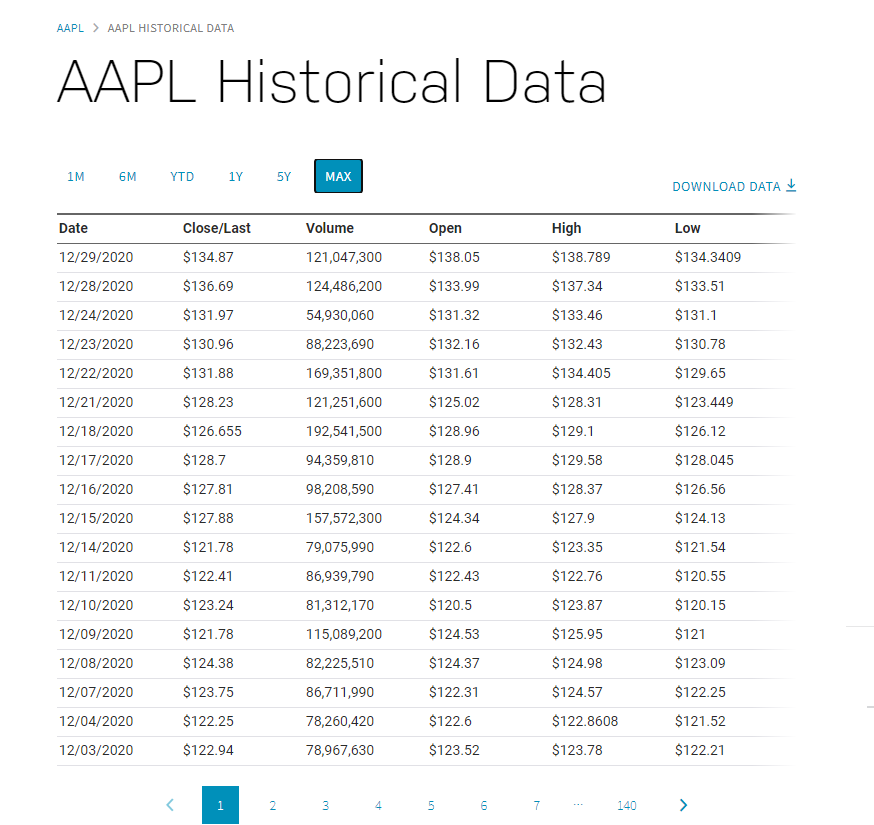

Chọn vào tùy chọn `MAX` để lấy dữ liệu trong 10 năm.

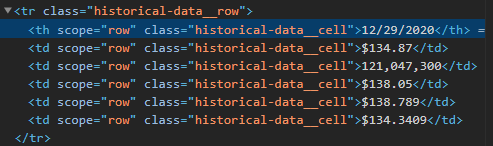

Với mỗi trang dữ liệu, mỗi dòng dữ liệu được lưu trong element có tên là `historical-data__row`. Lấy tất cả các element này để lấy tất cả các dòng. Từ các element đó, lấy dữ liệu bằng cách tách string với khoảng trắng.

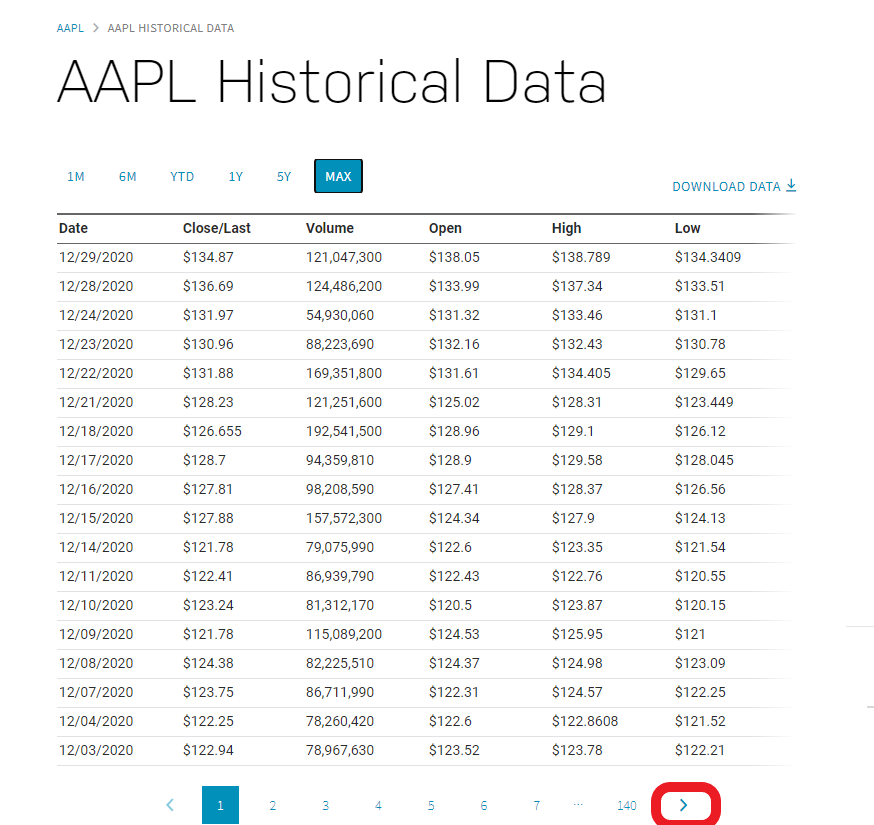

Sau khi lấy xong dữ liệu ở một trang, nhấn nút next để chuyển sang trang khác. Lặp lại quá trình đến khi nào hết dữ liệu.

---

# III/ Thông tin dữ liệu

### Thông tin về dữ liệu:


Trong sổ tay này, chúng ta sẽ xem xét dữ liệu từ thị trường chứng khoán, đặc biệt là một số cổ phiếu công nghệ. Sử dụng pandas để lấy thông tin cổ phiếu, hình dung các khía cạnh khác nhau của nó và cuối cùng ta sẽ xem xét một số cách phân tích rủi ro của cổ phiếu, dựa trên lịch sử hoạt động trước đó của nó. Chúng tôi cũng sẽ dự đoán giá cổ phiếu trong tương lai thông qua phương pháp Long Short Term Memory (LSTM)! 

**Nguồn: [tại đây](https://www.nasdaq.com/)**

## 1. Khám phá dữ liệu:

### Import

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

### 1.1 Đọc dữ liệu từ file csv vào dataframe

In [3]:
df = pd.read_csv("stock_data.csv", sep = '\t')
df.head()

,Date,Close/Last,Volume,Open,High,Low,Company
0,12/22/2020,$1720.22,1018829,$1729.33,$1732.6123,$1705.78,Alphabet
1,12/21/2020,$1734.56,1698707,$1709.13,$1737,$1694,Alphabet
2,12/18/2020,$1726.22,4262837,$1746.17,$1748.36,$1715,Alphabet
3,12/17/2020,$1740.51,1744005,$1763.93,$1766.71,$1731.15,Alphabet
4,12/16/2020,$1757.19,1233836,$1769.11,$1769.11,$1749.06,Alphabet


### 1.2 Thông tin thuộc tính:

In [4]:
#xem thông tin data:
df.info()

num_rows, num_cols = df.shape
print("Dữ liệu có {} dòng, {} cột.".format(num_rows, num_cols))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14734 entries, 0 to 14733
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         14734 non-null  object
 1    Close/Last  14734 non-null  object
 2    Volume      14734 non-null  int64 
 3    Open        14734 non-null  object
 4    High        14734 non-null  object
 5    Low         14734 non-null  object
 6   Company      14734 non-null  object
dtypes: int64(1), object(6)
memory usage: 805.9+ KB
Dữ liệu có 14734 dòng, 7 cột.


Trước khi đi vào phân tích, ta cần hiểu về một số khái niệm trong chứng khoán: Thị trường chứng khoán có thể phân làm 2 loại cơ bản là **thị trường cổ phiếu (Stock market)** và **thị trường trái phiếu (bond market)**. Trong đồ án này, ta chỉ khai thác và phân tích về thị trường cổ phiếu. 

Thông tin thuộc tính:
- **Date**: Thời gian (theo ngày) của dữ liệu cổ phiếu.
- **Colse/Last**: Đây là mức giá cuối cùng mà chứng khoán được giao dịch trong một thời kỳ. Do tính lợi ích của nó, mức giá Close là một trường được thường xuyên sử dụng nhất để phân tích. Các kỹ thuật viên cho rằng mối quan hệ giữa mức giá Open (Mức giá đầu tiên) và mức giá Close (Mức giá cuối cùng) rất có ý nghĩa. Mối quan hệ đó được nhấn mạnh trong biểu đồ giá đỡ nến (candlestick chart).
- **Volume**: Đây là số lượng cổ phiếu (hoặc hợp đồng)được giao dịch trong một ngày. Mối quan hệ giữa giá và khối lượng (ví dụ: tăng giá đi cùng với tăng khối lượng) rất quan trọng.
- **Open**: Đây là mức giá của lần giao dịch đầu tiên trong một thời kỳ (ví dụ: lần giao dịch đầu tiên trong ngày). Khi phân tích các dữ liệu hàng ngày giá Open đặc biệt quan trọng vì nó là mức giá nhất trí sau khi tất cả các bên quan tâm có thể “gác nó đến hôm sau”.
- **High**: Đây là mức giá cao nhất mà chứng khoán được giao dịch trong một thời kỳ. Đó là thời điểm mà tại đó có nhiều người bán hơn người mua (tức là: luôn có người bán sẵn sàng bán ở mức giá cao hơn, nhưng mức giá High miêu tả mức giá cao nhất mà người mua sẵn sàng trả tiền).
- **Low**: Đây là mức giá thấp nhất mà chứng khoán được giao dịch trong một giai đoạn. Đó là thời điểm mà tại đó có nhiều người mua hơn người bán (tức là: luôn có người mua sẵn sàng mua ở mức giá thấp hơn, nhưng mức giá Low miêu tả mức giá thấp nhất mà người bán sẵn sàng chấp nhận bán).
- **Company**: Tên công ty ứng với mã cổ phiếu.

Chi tiết tham khảo: [tại đây](https://hotroontap.com/phan-tich-ky-thuat-bang-bieu-do-chung-khoan/)

---

### 1.3 Tiền xử lý:

- Kiểm tra dữ thông tin dữ liệu: kiểu dữ liệu của các thuộc tính, các cột có bị thiếu giá trị hay không?...

In [5]:
#xem thông tin data:
df.info()

if df.isnull().values.any() == False:
    print("=> Không có ô giá trị nào bị thiếu.")
else:
    print("Dữ liệu bị thiếu.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14734 entries, 0 to 14733
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         14734 non-null  object
 1    Close/Last  14734 non-null  object
 2    Volume      14734 non-null  int64 
 3    Open        14734 non-null  object
 4    High        14734 non-null  object
 5    Low         14734 non-null  object
 6   Company      14734 non-null  object
dtypes: int64(1), object(6)
memory usage: 805.9+ KB
=> Không có ô giá trị nào bị thiếu.


- Định dạng lại kiểu dữ liệu cho phù hợp.

In [6]:
df_pre = df.copy()
#Định dạng lại cột Date sang kiểu dữ liệu datetime
df_pre["Date"] = pd.to_datetime(df_pre["Date"])

#Xóa khoảng trắng trong dữ liệu:
df_pre.columns = df_pre.columns.str.replace(' ', '') 
df_pre.replace(' ', '', regex=True, inplace = True)

#Đổi tên cột để tiện thao tác
df_pre.rename(columns = {'Close/Last':'Close'}, inplace = True)

#Chuyển cột có ký hiệu tiền tệ ($) sang dạng datetime:
df_pre['Close'] = df_pre['Close'].str.replace('$', '').astype(float)
df_pre['Open'] = df_pre['Open'].str.replace('$', '').astype(float)
df_pre['High'] = df_pre['High'].str.replace('$', '').astype(float)
df_pre['Low'] = df_pre['Low'].str.replace('$', '').astype(float)

#Sắp xếp cổ phiếu tăng dần theo ngày:
df_pre.sort_values(['Company', 'Date'], ascending=[True, True], inplace = True)

#Lấy tên tất cả công ty trong dữ liệu:
company_name = list(df_pre["Company"].unique())

- Kiểm tra tính liên tục của cột dữ liệu ngày, xem có bị thiếu hụt giá trị hay không:

In [7]:
mising_date = pd.date_range(start = df_pre.Date.min(), end = df_pre.Date.max(), freq = 'D').difference(df_pre.Date)
print("Có {} ngày bị thiếu trong bộ dữ liệu.".format(len(mising_date)))

Có 1133 ngày bị thiếu trong bộ dữ liệu.


-> Do đó ta cần bổ sung phần dữ liệu bị thiếu bằng phương pháp tính trung bình giá trị không thiếu gần nhất ở trước và sau:

In [8]:
data = pd.DataFrame(columns=df_pre.columns)
companies = df_pre.loc[:, 'Company'].unique()
for company in companies:
    one_company_df = df_pre.loc[df_pre.loc[:, 'Company'] == company]
    one_company_df.loc[:, 'Date'] = pd.to_datetime(one_company_df.loc[:, 'Date'])
    one_company_df = one_company_df.sort_values(by=['Date'], ascending=True)
    one_company_df.set_index('Date', inplace=True)

    r = pd.date_range(start=one_company_df.index.min(), end=one_company_df.index.max())
    one_company_df.index = pd.DatetimeIndex(one_company_df.index)
    one_company_df = one_company_df.reindex(r, fill_value=0)
    one_company_df = one_company_df.reset_index().rename(columns={'index': 'Date'})
    one_company_df = one_company_df.sort_values(by=['Date'], ascending=False).reset_index()
    one_company_df.loc[:, 'Company'] = company
    column_lists = ['Close', 'Volume', 'Open', 'High', 'Low']
    for column in column_lists:
        temp = one_company_df.loc[:, column]
        prev = 0
        nxt = 0
        i = 0
        while i < len(temp):
            if temp.iloc[i] != 0:
                prev = temp[i]
                i += 1
            else:
                for j in range(i, len(temp)):
                    if temp.iloc[j] != 0:
                        nxt = temp.iloc[j]
                        temp.iloc[i:j] = (prev + nxt) / 2
                        i = j
                        break
        one_company_df.loc[:, column] = temp
    data = data.append(one_company_df)

data = data.reset_index().drop(columns=['level_0', 'index'])
data = data.set_index('Date')

- Dữ liệu sau khi tiền xử lý:

In [9]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21376 entries, 2020-12-22 to 2010-12-29
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Close    21376 non-null  float64
 1   Volume   21376 non-null  float64
 2   Open     21376 non-null  float64
 3   High     21376 non-null  float64
 4   Low      21376 non-null  float64
 5   Company  21376 non-null  object 
dtypes: float64(5), object(1)
memory usage: 1.1+ MB


,Close,Volume,Open,High,Low,Company
Date,,,,,,
2020-12-22,1720.22,1018829.0,1729.33,1732.6123,1705.78,Alphabet
2020-12-21,1734.56,1698707.0,1709.13,1737.0000,1694.00,Alphabet
2020-12-20,1730.39,2980772.0,1727.65,1742.6800,1704.50,Alphabet
2020-12-19,1730.39,2980772.0,1727.65,1742.6800,1704.50,Alphabet
2020-12-18,1726.22,4262837.0,1746.17,1748.3600,1715.00,Alphabet


In [10]:
# Summary Stats
data.describe()

,Close,Volume,Open,High,Low
count,21376.000000,2.137600e+04,21376.000000,21376.000000,21376.000000
mean,336.269486,6.109107e+07,336.288751,339.773838,332.460553
std,527.413639,1.210425e+08,527.665139,533.330347,521.125095
min,4.366000,5.211410e+05,4.356000,4.454000,4.222000
25%,38.856875,3.676804e+06,38.847500,39.326250,38.330000
50%,94.890000,2.112960e+07,94.910000,96.015000,93.662000
75%,359.054000,5.203540e+07,358.965000,362.900000,354.485000
max,3531.450000,1.849768e+09,3547.000000,3552.250000,3486.685000


---
# IV/ Đặt câu hỏi:
- 1. Cổ phiếu của công ty nào có giá trị nhất? Mang tính tham khảo về thị trường cổ phiếu công nghệ, giúp ta có cái nhìn tổng quát ban đầu.

- 2. Để có thể đưa ra quyết định đầu tư khi mới bắt đầu mua cổ phiếu, xét đến tính phổ biến. Vậy khối lượng giao dịch cổ phiếu của các công ty??

- 3. Tác động của đại dịch Covid-19 đến tình hình kinh tế của các công ty? Điều đó quyết định đến chuyện nên bán ra/mua vào cổ phiếu trong từng giai đoạn.

- 4. Kiểm chứng model LSTM áp dụng cho giá cổ phiếu của Alphabet bằng dữ liệu ta có. Từ đó dự đoán giá cổ phiếu cho ngày tiếp theo sau ngày cuối trong dữ liệu?



---

# V/ Tìm câu trả lời:

1. **<font color=red>Cổ phiếu của công ty nào có giá trị nhất? </font>**

- Sử dụng biểu đồ Box để thể hiện giá trị cổ phiếu của các công ty trong 10 năm qua:

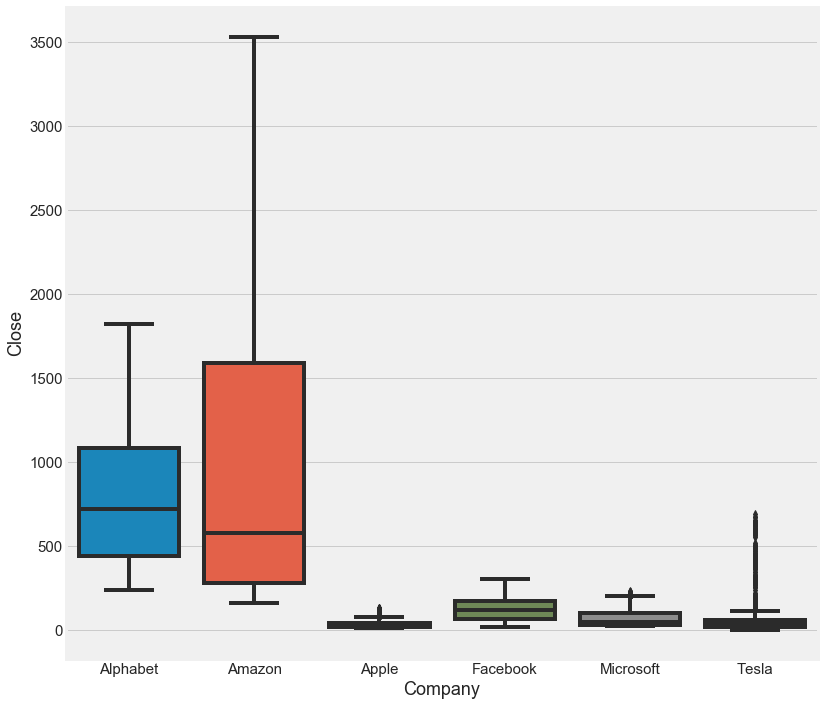

In [11]:
# create plot
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(12,12))
ax = sns.boxplot(x="Company", y="Close", data=data)

**Nhận xét:** Qua biểu đồ trên, ta thấy giá trị cổ phiếu của Alphabet và Amazon đang bỏ xa các công ty lớn khác. Trong quá trình 10 năm trở lại đây, cổ phiếu của Amazon có lúc đã vượt ngưỡng 3500$/cổ phiếu, con số này thực sự rất lớn nếu so sánh với các công ty khác như Apple, Facebook, Tesla... 

2. **<font color=red>Để có thể đưa ra quyết định đầu tư khi mới bắt đầu mua cổ phiếu, xét đến tính phổ biến. Vậy khối lượng giao dịch cổ phiếu của các công ty? </font>**

- Tạo hàm để tạo Serie chứa index là tên công ty và value là tổng số cổ phiếu đã giao dịch:

In [12]:
def count_volume(df, company_name):
    list_sum = []
    for i in range(len(company_name)):
        df_temp = df[df['Company'] == company_name[i]]
        list_sum.append(df_temp['Volume'].sum())
    series_count_volume = pd.Series(list_sum, index = company_name)
    return series_count_volume

- Thu được kết quả:

In [13]:
series_count_volume = count_volume(data, company_name)
series_count_volume

Alphabet     7.808867e+09
Amazon       1.572857e+10
Apple        9.264819e+11
Facebook     9.970618e+10
Microsoft    1.367338e+11
Tesla        1.194234e+11
dtype: float64

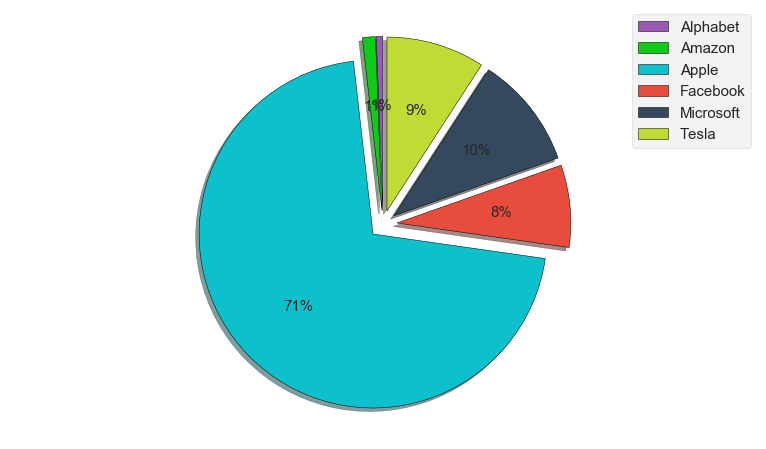

In [14]:
#Trực quan %
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(12,8))
plt.axis('equal')

colors = ["#9b59b6", "#0ccc16", "#0cc1cc", "#e74c3c", "#34495e", '#c2db34']
plt.pie(series_count_volume, startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, 
        explode = ([0.08] * 6), autopct='%1.f%%',shadow=True);
plt.legend(loc='best', labels=series_count_volume.index, fontsize='medium')
plt.show()

**Nhận xét:** Kết quả cho thấy Apple là công ty có lượng cổ phiếu giao dịch nhiều nhất, chiếm đến 71% của bộ dữ liệu. Do đó, nếu bạn mới bước chân vào ngành chứng khoán, quyết định đầu tư theo số đông, thì cổ phiếu Apple đáng để xem xét. Tuy nhiên, lượng giao dịch đôi khi phản ánh không đúng thị trường, khi lượng bán ra nhiều hơn lượng mua, đồng nghĩa với việc quyết định trên không còn đáng tin cậy nữa. 

3. **<font color=red>Tác động của đại dịch Covid-19 đến tình hình kinh tế của các công ty? </font>**

- Đầu tiên cần thực hiện bước tiền xử lý nhằm lấy ra dữ liệu của 1 khoảng thời gian trong tập:

In [15]:
def get_records_in_time_period(df, start_date, end_date, company_name=None):
    '''
    Hàm get_records_in_time_period sẽ lấy các records của công ty trong một khoảng thời gian từ một dataframe
    Tham số df: dataframe nguồn chứa các records.
    Tham số start_date: mốc thời gian bắt đầu.
    Tham số end_date: mốc thời gian kết thúc.
    Tham số company_name: tên công ty cần lấy record, mặc định None sẽ lấy toàn bộ.
    Output: một dataframe chứa các records với tất cả các cột dữ liệu.
    '''
    # nếu không truyền vào tên công ty, mặc định sẽ lấy toàn bộ các công ty trong khoảng thời gian
    if company_name is None:
        return df.loc[(df.index >= start_date) & (df.index <= end_date)]
    # ngược lại, nếu có tham số tên công ty được truyền vào, chỉ lấy các dòng của công ty đó
    else:
        company_df = df[df['Company'] == company_name]
        time_period_filter = (company_df.index >= start_date) & (company_df.index <= end_date)
        return company_df.loc[time_period_filter]

- Hiển thị biểu đồ đường giá Close của cổ phiếu trong giai đoạn đầu năm 2020 đến nay:

<a list of 6 Text xticklabel objects>
[0.  0.2 0.4 0.6 0.8 1. ]


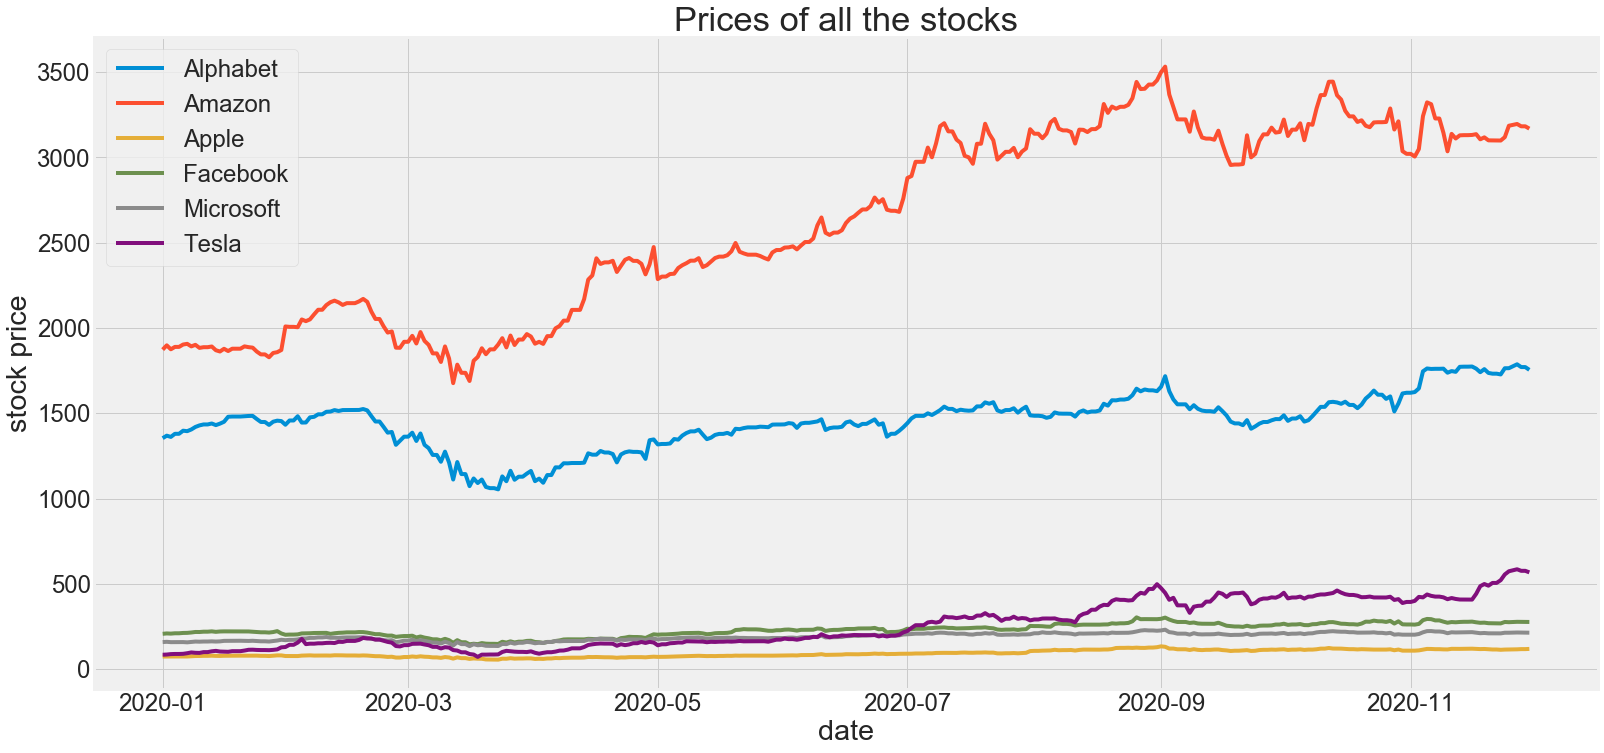

In [16]:
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(24,12))
plt.title('Prices of all the stocks')
plt.ylabel('stock price')
plt.xlabel('date')

locs, labels = plt.xticks()
print(labels)
print(locs)

for company in company_name:
    data_company = get_records_in_time_period(data, '2020-01-01', '2020-11-30', company_name=company)
    plt.plot(data_company.index,data_company.Close, label=company)
    plt.legend()

**Nhận xét:** Ta thấy giá cổ phiếu các công ty đều tụt dốc vào giai đoạn đầu tháng 3, lúc dịch Covid bắt đầu bùng phát và lan nhanh ở nhiều nơi trên thế giới. Tuy nhiên tình hình ổn định hơn kể từ tháng 4, các công ty thương mại điện tử như Amazon tăng trưởng vượt bậc do nhu cầu mua sắm online trong thời kỳ cách ly. 

4. **<font color=red>Kiểm chứng model LSTM áp dụng cho giá cổ phiếu của Alphabet bằng dữ liệu ta có. Từ đó dự đoán giá cổ phiếu cho ngày tiếp theo sau ngày cuối trong dữ liệu? </font>**

Để tạo mô hình huấn luyện, bước đầu tiên ta cần phải chuẩn bị dữ liệu cho mô hình. Ở đây, ta sẽ làm việc với cột giá trị stock lúc đóng phiên giao dịch của Alphabet. Sau đó chuẩn hóa dữ liệu bằng `MinMaxScaler` của sklearn. 

In [17]:
src_stock = data[data['Company'] == 'Alphabet']['Close'].iloc[::-1]
alpha_stock = src_stock.values
alpha_stock = alpha_stock.reshape(len(alpha_stock), 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_stock = scaler.fit_transform(alpha_stock)
scaled_stock

array([[0.04019269],
       [0.03951071],
       [0.03795231],
       ...,
       [0.94033134],
       [0.94296211],
       [0.93391529]])

Với dữ liệu này, ta lấy 20% dòng cuối để làm giá trị test, còn lại ta dùng cho việc huấn luyện mô hình.

In [18]:
train_values = scaled_stock[:int(len(alpha_stock) * 0.8)]
train_values

array([[0.04019269],
       [0.03951071],
       [0.03795231],
       ...,
       [0.4740225 ],
       [0.4719469 ],
       [0.4719469 ]])

Sau đó, tạo ra tập X_train và Y_train.
- Với Y_train, ta lấy giá trị stock của một ngày.
- Với X_train, ta lấy giá trị của 100 dòng giá trị trước ngày đó.

In [19]:
X_train, Y_train = [], []

for i in range(100, len(train_values)):
    X_train.append(train_values[i - 100:i])
    Y_train.append(train_values[i])

In [20]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Bắt đầu xây dựng mô hình huấn luyện. Các dòng có ý nghĩa như sau:
- Dòng 1: khởi tạo model.
- Dòng 2: thêm layer LSTM vào model. Layer này có các tham số như `units` = 128 là kích thước chiều của output, `return_sequences=True` để trả về output, `input_shape` để xác định chiều của input.
- Dòng 3: thêm layer LSTM thứ 2. Layer này có 64 units và không trả về output.
- Dòng 4: thêm layer `Dense`. Layer này có tham số là 25, nghĩa là số chiều của output là 25.
- Dòng 5: thêm layer `Dense` thứ 2. Layer này có tham số là 1, nghĩa là output chỉ còn 1 chiều.
- Dòng 6: compile model với tham số `optimizer` để tạo metrics tính toán và `loss` để model xác định cách giảm thiểu lỗi.
- Dòng 7: fit model với các tập train. Tham số `batch_size` để xác định số lượng sample mỗi lần update gradient, tham số `epochs` xác định kích thước epoch để train model.

Việc lặp các layer để tăng độ phức tạp và không gian của model, từ đó có thể có được kết quả train tốt hơn.

In [21]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=1, epochs=1)

2817/2817 [==============================] - 105s 37ms/step - loss: 5.3320e-04


Sau khi tạo và huấn luyện mô hình cho tập huấn luyện, ta tạo dữ liệu cho tập test. Ta lấy thêm 100 dòng từ dữ liệu train để có thể dự đoán giá trị đầu tiên trong tập test.

In [22]:
test_values = scaled_stock[int(len(alpha_stock) * 0.8) - 100:]

In [23]:
X_test = []
Y_test = alpha_stock[int(len(alpha_stock) * 0.8):, :]

for i in range(100, len(test_values)):
    X_test.append(test_values[i - 100:i])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))


Áp dụng mô hình cho tập dữ liệu test.

In [24]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

Tính độ lỗi RMSE cho tập dự đoán và tập test.

In [25]:
rmse = np.sqrt(np.mean(((predictions - Y_test) ** 2)))
rmse

39.90646630145326

Từ các tập dữ liệu huấn luyện, tập dự đoán và tập kết quả, ta vẽ đồ thị để dễ dàng quan sát.

In [26]:
src_stock

Date
2010-12-29     303.5921
2010-12-30     302.5111
2010-12-31     300.0409
2011-01-01     302.6626
2011-01-02     302.6626
                ...    
2020-12-18    1726.2200
2020-12-19    1730.3900
2020-12-20    1730.3900
2020-12-21    1734.5600
2020-12-22    1720.2200
Name: Close, Length: 3647, dtype: float64

In [27]:
train_set = src_stock.iloc[:int(0.8 * len(src_stock))]
test_set = src_stock.iloc[int(0.8 * len(src_stock)):]
prediction_set = pd.Series(predictions.reshape(len(predictions)))
prediction_set.index = test_set.index

In [28]:
prediction_set

Date
2018-12-24    1012.666687
2018-12-25    1006.220947
2018-12-26    1008.201416
2018-12-27    1018.996338
2018-12-28    1031.456543
                 ...     
2020-12-18    1689.970459
2020-12-19    1683.075073
2020-12-20    1677.798828
2020-12-21    1674.264893
2020-12-22    1673.010986
Length: 730, dtype: float32

In [29]:
test_set

Date
2018-12-24     984.67
2018-12-25    1016.26
2018-12-26    1047.85
2018-12-27    1052.90
2018-12-28    1046.68
               ...   
2020-12-18    1726.22
2020-12-19    1730.39
2020-12-20    1730.39
2020-12-21    1734.56
2020-12-22    1720.22
Name: Close, Length: 730, dtype: float64

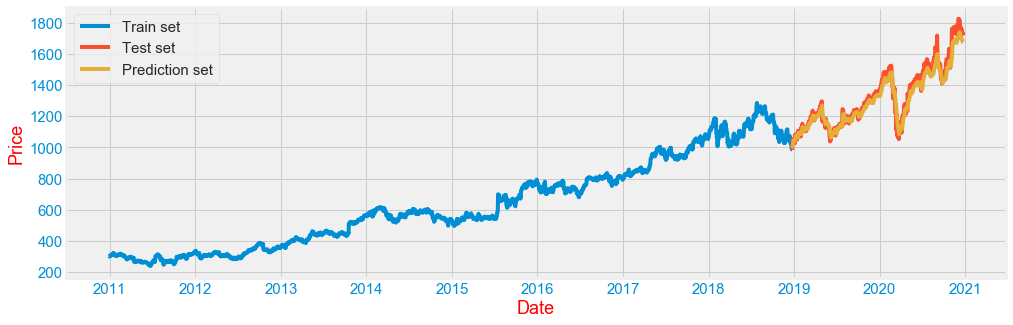

In [30]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(15, 5))
plt.xlabel('Date', color="red")
plt.ylabel('Price', color="red")
plt.plot(train_set)
plt.plot(test_set)
plt.plot(prediction_set)
plt.tick_params(axis='x', colors="C0")
plt.tick_params(axis='y', colors="C0")
plt.legend(['Train set', 'Test set', 'Prediction set'], loc='upper left')
plt.show()

#### Nhận xét: 
- Từ độ lỗi và biểu đồ trực quan, ta có thể thấy mô hình LSTM này khá phù hợp với việc dự đoán giá cổ phiếu, chủ yếu là vì mô hình này phù hợp với loại dữ liệu liên tục và có sự kết giữa các mốc giá trị.
- Đối với những ngày có sự thay đổi không lớn (không đột ngột), mô hình dự đoán khá chính xác, tuy nhiên, với những ngày có giá biến động thất thường, mô hình cho ra kết quả dự đoán tương đối lệch. Điều này là hiển nhiên không thể tránh khỏi, vì mô hình LSTM mà ta đang sử dụng tương đối đơn giản, dữ liệu mà ta sử dụng cũng vậy, chỉ có vài cột dữ liệu. Bên cạnh đó, sự thay đổi trong giá cổ phiếu còn phụ thuộc vào rất nhiều yếu tố ngoài đời thực khác (như đại dịch, chủ tịch qua đời, sản phẩm mới ra mắt thành công hoặc thất bại, vướng phải kiện tụng,...). ***Vì thế, việc sử dụng mô hình này để dự đoán chỉ mang tính chất tham khảo.***

Xây dựng hàm `lstm_model` để có thể áp dụng cho nhiều công ty.
- Hàm này yêu cầu tham số là dataframe dữ liệu, tên công ty và một số nguyên là giá trị độ dài một dòng input mà ta mong muốn.
- Cách hoạt động của hàm:
    - Chia tập dữ liệu thành 2 phần: 80% đầu dành cho việc train và 20% còn lại dành cho việc test.
    - Với mỗi giá trị cổ phiếu, ta lấy giá trị cổ phiếu của N ngày trước đó để làm input cho việc huấn luyện, và giá trị ngày đó làm output.
    - Tiếp tục lặp với toàn bộ tập train để có được model.
- Sau khi hoàn thành việc huấn luyện mô hình, hàm sẽ trả về một vài giá trị như:
    - `model`: mô hình LSTM đã huấn luyện.
    - `scaler`: mô hình chuẩn hóa dữ liệu.
    - `rmse`: độ lỗi trên tập test.

In [31]:
def lstm_model(df, company_name, input_len=100):
    '''
    Hàm lstm_model sẽ tạo một LSTM model đã qua việc train với 80% lượng dữ liệu ta có.
    Tham số df: dataframe chứa dữ liệu để tạo model.
    Tham số company_name: tên công ty để lấy dữ liệu.
    Tham số input_len: độ dài của một dòng input.
    Output: một model LSTM đã qua việc huấn luyện, mô hình chuẩn hóa dữ liệu, độ lỗi trên tập test.
    '''
    
    stock = df[df['Company'] == company_name]['Close'].values
    stock = stock.reshape(len(stock), 1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_stock = scaler.fit_transform(stock)

    train_values = scaled_stock[:int(len(stock) * 0.8)]
    X_train, Y_train = [], []
    
    for i in range(input_len, len(train_values)):
        X_train.append(train_values[i - input_len:i])
        Y_train.append(train_values[i])

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # tạo mô hình LSTM để huấn luyện
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, Y_train, batch_size=1, epochs=1)
    
    test_values = scaled_stock[int(len(stock) * 0.8) - input_len:]
    X_test = []
    Y_test = stock[int(len(stock) * 0.8):, :]

    for i in range(input_len, len(test_values)):
        X_test.append(test_values[i - input_len:i])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    
    rmse = np.sqrt(np.mean(((predictions - Y_test) ** 2)))

    return model, scaler, rmse


---

# VI/ Nhìn lại quá trình làm đồ án

Qua quá trình làm đồ án, nhóm rút ra một số ý:

> ***Thuận lợi:***
- Dữ liệu sạch và không cần tiền xử lý nhiều.
- Kích thước dữ liệu không quá lớn (đối với học máy) nên việc chạy code khá nhanh.

> ***Khó khăn:***
- Có những key word trong chứng khoán và kinh tế khó để hiểu và giải thích.
- Dữ liệu bị mất nhiều hàng và không liên tục nên phải bù vào, ảnh hưởng đến kết quả chạy model học máy.

Sau khi thực hiện đồ án này, nhóm có được cái nhìn trực quan về dữ liệu cổ phiếu, hiểu được một vài khái niệm và tính chất chung của giá cổ phiếu các công ty, áp dụng được những kiến thức về khoa học dữ liệu để trực quan và dự đoán,...

Nếu có thêm thời gian, nhóm sẽ nghiên cứu kỹ hơn về các tính chất của giá cổ phiếu để đưa ra các câu hỏi tốt hơn, tìm hiểu thêm những công thức chứng khoán chuyên sâu,từ đó áp dụng vào thực tiễn.

# VII/ Tài liệu tham khảo:

- Stackoverflow: [link](https://stackoverflow.com/questions/54567770/how-to-build-an-lstm-time-series-forecasting-model-in-python)
 
- Kaggle: [link](https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm?fbclid=IwAR2UcxXp2AlI1_pLTRWpbQR8vGcogn1rM3ZXounLoaSCGR3vOIg-Vw38BtA)